In [2]:
%matplotlib inline
import pandas as pd

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df0 = pd.read_csv('heart.csv')

In [4]:
df0.head(20)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [5]:
# Seleciona colunas e remove os NaNs
df1 = df0.dropna()
df = df1.rename(columns={'Age': 'idade', 'Sex': 'sexo', 'Cholesterol': 'nivel_colesterol', 'HeartDisease': 'doencas_cardiacas' })
df.head()

,idade,sexo,ChestPainType,RestingBP,nivel_colesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,doencas_cardiacas
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


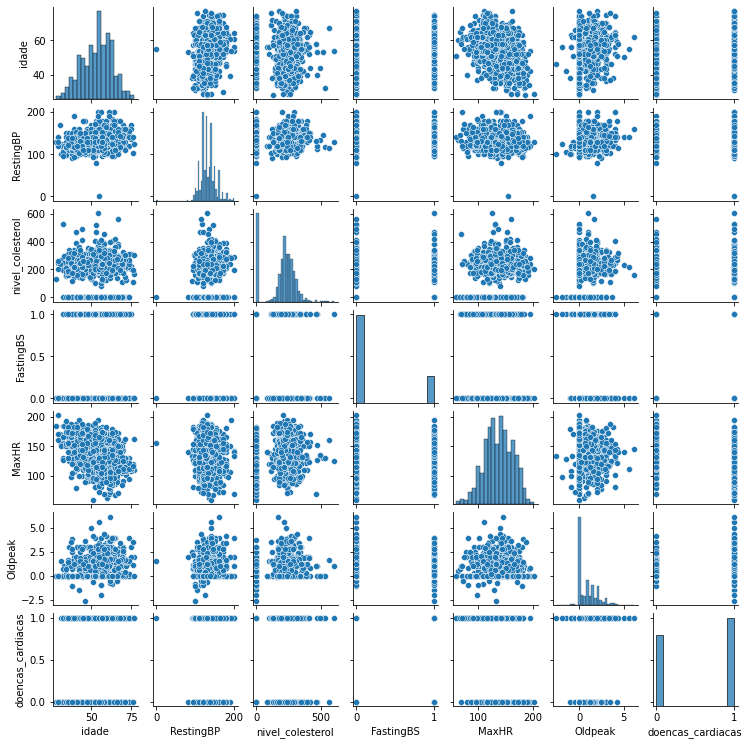

In [6]:
sns.pairplot(df, height=1.5);

In [7]:
df.describe()

,idade,RestingBP,nivel_colesterol,FastingBS,MaxHR,Oldpeak,doencas_cardiacas
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [8]:
df.isnull().sum()

idade                0
sexo                 0
ChestPainType        0
RestingBP            0
nivel_colesterol     0
FastingBS            0
RestingECG           0
MaxHR                0
ExerciseAngina       0
Oldpeak              0
ST_Slope             0
doencas_cardiacas    0
dtype: int64